In [2]:
import sys
sys.path.append("../../")
from Dataloader.Dataset import *
import gc
import numpy as np
import scanpy as sc
import squidpy as sq
import tqdm
from venny4py.venny4py import *
%matplotlib inline



Although histology images and their paired spatial transcriptomics share some information, it is unlikely that the features of the images can accurately predict the expression of all genes, and vice versa.

Nevertheless, it is crucial to prioritize the expression of marker genes for cell types or subtypes (MG), highly expressed genes (HEG), and highly variable genes (HVG), as they are often the most biologically relevant candidates for disease diagnosis and drug development.

It's worth noting that the applicability of these marker genes may vary based on the type of disease. Marker genes are highly dependent on the disease type, and HEG and HVG may not necessarily be correlated with cancer or other diseases.

To address this, we opt for functional genes provided by a commercial company. We then take the intersection of genes detected by Visium and these functional genes to create a target gene list.

# Target gene selction method

In [4]:
def preprocess_adata(adatas):
    for adata in adatas:
        adata.var_names_make_unique()  
        # sc.pp.filter_cells(adata, min_genes=10)
#         sc.pp.filter_genes(adata, min_cells=100)
        sc.pp.log1p(adata)
    return adatas

In [11]:
# Find the highly variable genes
def find_hvgs(adatas, dataset_name="Liver", save=True):
    for adata in adatas:
        # sc.pp.highly_variable_genes(adata, min_mean=0.0, inplace=True)
        sc.pp.highly_variable_genes(adata, n_top_genes=1000, subset=True)
        print(adata.shape)
    hvgs = [list(adata.var_names) for adata in adatas]
    print(hvgs[0], hvgs[1])

    # Find the intersection of all four lists
    intersect_result = set(hvgs[0])
    for i in range(len(hvgs)):
        intersect_result = intersect_result.union(hvgs[i])

    # Convert the result back to a list if needed
    intersect_list = list(intersect_result)
    print("Union of hvgs across samples:", len(intersect_list))
    
    if save:
        # Save the array to a file
        np.save(f'../../Dataset/Gene_list/Gene_list_svg_{dataset_name}.npy', np.array(intersect_list))
    return intersect_list


In [12]:
# Spatial variable genes
def find_svgs(adatas, dataset_name="Liver", save=True):
    svgs = []
    threshold = 0.5
    for adata in adatas:
        sq.gr.spatial_neighbors(adata)
        sq.gr.spatial_autocorr(adata, mode="moran", genes=adata.var_names)
        moranI = adata.uns["moranI"]
        print("Threshold:", moranI["I"].median())
        svg = list(moranI[moranI["I"]>moranI["I"].median()].index)
        svgs.append(svg)
    
    # Find the intersection of all four lists
    intersection_result = set(svgs[0])
    for i in range(len(svgs)):
        intersection_result = intersection_result.intersection(svgs[i])

    # Convert the result back to a list if needed
    intersection_list = list(intersection_result)
    
    print("Intersection:", len(intersection_list))
    
    if save:
        # Save the array to a file
        np.save(f'../../Dataset/Gene_list/Gene_list_hvg_{dataset_name}.npy', np.array(intersection_list))
        
    return intersection_list


In [17]:
# Functional genes
def find_inter_adata_varnames(adatas):
    init = set(adatas[0].var_names)
    for i in range(len(adatas)):
        init = init & set(adatas[i].var_names)
    init = list(init)
    print(f"The length of concatenated adata gene list: {len(init)}")
    return init

def find_func_genes(adatas, dataset_name, save=False):
    common_genes = find_inter_adata_varnames(adatas)
    Cancer_Immunology = list(np.load('../../Dataset/Gene_list/Cancer_Immunology.npy',allow_pickle=True))
    Panel_6000 = list(np.load('../../Dataset/Gene_list/Panel_6000.npy',allow_pickle=True))
    functional_genes = list(set(common_genes) & set(Cancer_Immunology) & set(Panel_6000))
    print("Functional_genes:", len(functional_genes))
    
    if save:
        # Save the array to a file
        np.save(f'../../Dataset/Gene_list/Gene_list_func_{dataset_name}.npy', np.array(functional_genes))
    return functional_genes
    

## Load adata

In [ ]:
def concat_adatas(dataset_name):
    # Skin cancer cSCC dataset
    if dataset_name == "Skin_cSCC":
        # Bugs in the dataset
        # exclude these genes 'NOG', 'FGF1', 'ANGPT1', 'MAPK10', 'SIX1', 'RASGRF1', 'DTX1'
        adatas = []
        for i in range(11):
            gc.collect()
            target_gene_list = ['NOG']
            te_data = CSCC(train=False, fold=i, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", exp_norm="log1p",
                            gene_list=target_gene_list)
            adata_dict = te_data.meta_dict
            adatas.append(adata_dict[list(adata_dict.keys())[0]])
        adatas = preprocess_adata(adatas)
    elif dataset_name == "BC_Her2ST":
        # Breast cancer Her2ST dataset
        target_gene_list = np.load("/home/uqyjia11/Downloads/RDM_DeepHis2Exp/Dataset/Gene_list/Gene_list_func_BC_Her2ST.npy", allow_pickle=True)
        adatas = []
        for i in range(36):
            gc.collect()
            te_data = Her2st(train=False, fold=i, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", gene_list=target_gene_list)
            adata_dict = te_data.meta_dict
            adatas.append(adata_dict[list(adata_dict.keys())[0]])
        adatas = preprocess_adata(adatas)
    elif dataset_name == "BC_visium":
        # BC_Visium dataset
        
        # Dataset path
        data_dir1 = "/afm01/UQ/Q2051/DeepHis2Exp/Dataset/Alex_NatGen_6BreastCancer/"
        data_dir2 = "/afm01/UQ/Q2051/DeepHis2Exp/Dataset/breast_cancer_10x_visium/"

        # Sample names
        samps1 = ["1142243F", "CID4290", "CID4465", "CID44971", "CID4535", "1160920F"]
        samps2 = ["block1", "block2", "FFPE"]

        # Store all adata into one dictionary, key is the slide name, value is the anndata objects
        name_slides = samps1+samps2
        print(name_slides)

        # Store sample's path into dictionary
        samples1 = {i:data_dir1 + i for i in samps1}
        samples2 = {i:data_dir2 + i for i in samps2}
            
        # Read preprocessing adata
        adata_dict1 = {name: sc.read_h5ad(f"{data_dir1}processed_adata/{name}.h5ad") for name, path in tqdm.tqdm(samples1.items())}
        adata_dict2 = {name: sc.read_h5ad(f"{data_dir2}processed_adata/{name}.h5ad") for name, path in tqdm.tqdm(samples2.items())}


        adatas = []
        gc.collect()
        for i, m in adata_dict1.items():
            adatas.append(m)
        for i, m in adata_dict2.items():
            adatas.append(m)
        adatas = preprocess_adata(adatas)
    elif dataset_name == "Liver_visium":
        # Liver disease dataset
        data_path = "/afm03/Q2/Q2051/DeepHis2Exp/Dataset/liver_Viisum/"
        gene_list = list(np.load('../Models/Benchmarking_Liver_BLEEP/Gene_list_hvg.npy',allow_pickle=True))
        adatas = []
        for i in range(4):
            gc.collect()
            te_data = Liver_visium(train=False, fold=i, r=112, num_subsets=1,
                            neighs=4, color_norm="raw", gene_list=gene_list)
            adata_dict = te_data.meta_dict
            adatas.append(adata_dict[list(adata_dict.keys())[0]])
        adatas = preprocess_adata(adatas)
    elif dataset_name == "Skin_Melanoma":
        # Skin cancer menaloma dataset
        data_path = "/afm03/Q2/Q2051/DeepHis2Exp/Dataset/Skin_Melanoma/"
        name_slides = ["Visium29_B1", "Visium29_C1", "Visium37_D1", "Visium38_B1", "Visium38_D1"]
        adatas = [sc.read_visium(f"{data_path}{name_slide}") for name_slide in name_slides]
        adatas = preprocess_adata(adatas)
    return adatas

In [ ]:
dataset_name = "Skin_cSCC" # "Skin_cSCC", "BC_Her2ST", "BC_visium", "Liver_visium", "Skin_Melanoma", "Kidney_visium"
adatas = concat_adatas(dataset_name)
print("No. of spots:", sum([adata.shape[0] for adata in adatas]))
init = set(adatas[0].var_names)
for adata in adatas:
     init = init & set(adata.var_names)
print("No. of genes", len(init))


No. of spots: 19968
No. of genes 36601


## Find the hvgs 

In [ ]:
hvg_list = find_hvgs(adatas, dataset_name=dataset_name, save=True)
print(hvg_list)

## Find the svgs

In [ ]:
svg_list = find_svgs(adatas, dataset_name=dataset_name, save=True)
svg_list

## Find the functional genes

In [ ]:
# "BC_visium", "BC_her2st", "SCC_Chenhao", "Skin_cscc", "SCC_external", "Liver_bleep"
# x = np.load('../Dataset/Gene_list/Gene_list_func_Skin_cSCC.npy',allow_pickle=True)
# func_gene = np.array(list(set(x) -set(['NOG', 'FGF1', 'ANGPT1', 'MAPK10', 'SIX1', 'RASGRF1', 'DTX1'])))
# np.save('../Dataset/Gene_list/Gene_list_func_Skin_cSCC.npy', func_gene)
func_genes = find_func_genes(adatas, dataset_name=dataset_name, save=True)
print(func_genes)

In [20]:
# Concat the gene list from visium
concatenated_adata = set(adatas[0].to_df().columns)
for adata in adatas:
    concatenated_adata = concatenated_adata & set(adata.to_df().columns)
concatenated_adata = set(concatenated_adata)

Cancer_Immunology = np.load('../../Dataset/Gene_list/Cancer_Immunology.npy',allow_pickle=True)
Panel_6000 = np.load('../../Dataset/Gene_list/Panel_6000.npy',allow_pickle=True)

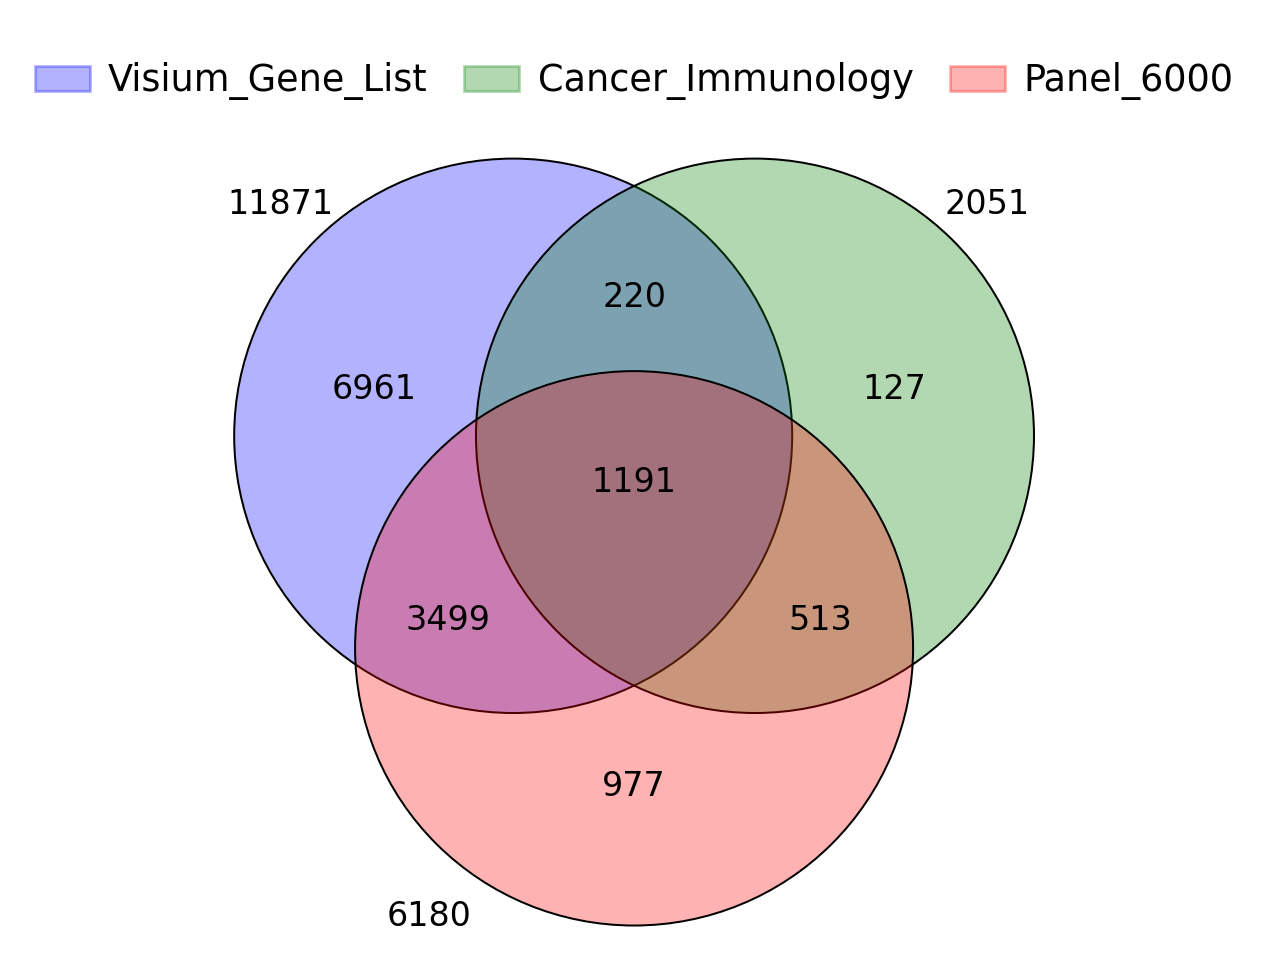

In [21]:
# Venn diagram for the intersection of gene lists
sets = {
    'Visium_Gene_List': concatenated_adata,
    'Cancer_Immunology': set(Cancer_Immunology),
    'Panel_6000': set(Panel_6000),
}

venny4py(sets=sets, size=6, dpi=300, out='./', ext='pdf')
